<a href="https://colab.research.google.com/github/konstantin-larin/football-predictor/blob/main/Football_Predictor_RCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загружаем и импортруем все нужные библиотеки

In [ ]:
!pip install kagglehub

In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Загружаем датасеты

In [ ]:
def LOAD_DATA():
  path_1 = kagglehub.dataset_download("davidcariboo/player-scores")
  path_2 = kagglehub.dataset_download("adamgbor/club-football-match-data-2000-2025")
  appearances = pd.read_csv(path_1 + '/appearances.csv')
  club_games = pd.read_csv(path_1 + '/club_games.csv')
  clubs = pd.read_csv(path_1 + '/clubs.csv')
  competitions = pd.read_csv(path_1 + '/competitions.csv') #applied
  game_events = pd.read_csv(path_1 + '/game_events.csv')
  game_lineups = pd.read_csv(path_1 + '/game_lineups.csv')
  games = pd.read_csv(path_1 + '/games.csv')
  players = pd.read_csv(path_1 + '/players.csv')
  player_valuations = pd.read_csv(path_1 + '/player_valuations.csv')
  transfers = pd.read_csv(path_1 + '/transfers.csv')
  # add elo_ratings
  elo_ratings = pd.read_csv(path_2 + '/EloRatings.csv')
  DATA =  {
      'appearances': appearances,
      'club_games': club_games,
      'clubs':clubs,
      'competitions': competitions,
      'game_events': game_events,
      'game_lineups': game_lineups,
      'games': games,
      'players': players,
      "player_valuations": player_valuations,
      'transfers': transfers,
      'elo_ratings': elo_ratings
          }
  def get_dataset(name):
    return DATA[name].copy()
  return get_dataset
get_dataset = LOAD_DATA()

100%|██████████| 165M/165M [00:00<00:00, 173MB/s]

Extracting files...


100%|██████████| 12.1M/12.1M [00:00<00:00, 185MB/s]

Extracting files...


## Функция для проверки **модели**

In [ ]:
def test_model(model, X_test, y_test):
  y_pred_proba = np.clip(model.predict_proba(X_test), 1e-15, 1)
  y_pred = np.argmax(y_pred_proba, axis=1)
  #Используем метрики для оценки точности модели
  accuracy = accuracy_score(y_test, y_pred)
  print('Общая доля верно классифицированных исходов матчей:', np.round(accuracy, 2))

  precision_draw = precision_score(y_test == 0, y_pred == 0)
  print('Доля правильно предсказанных ничей:', np.round(precision_draw, 2))
  precision_1 = precision_score(y_test == 1, y_pred == 1)
  print('Доля правильно предсказанных побед домашней команды:', np.round(precision_1, 2))
  precision_2 = precision_score(y_test == 2, y_pred == 2)
  print('Доля правильно предсказанных побед гостевой команды:', np.round(precision_2, 2))

  recall_draw = recall_score(y_test == 0, y_pred == 0)
  print('Доля фактически наступивших ничей, которые были верно предсказаны:', np.round(recall_draw, 2))
  recall_1 = recall_score(y_test == 1, y_pred == 1)
  print('Доля фактически наступивших побед домашней команды, которые были верно предсказаны:', np.round(recall_1, 2))
  recall_2 = recall_score(y_test == 2, y_pred == 2)
  print('Доля фактически наступивших побед гостевой команды, которые были верно предсказаны:', np.round(recall_2, 2))

  f1_draw = f1_score(y_test == 0, y_pred == 0)
  print('F1-мера для ничей:', np.round(f1_draw, 2))
  f1_1 = f1_score(y_test == 1, y_pred == 1)
  print('F1-мера для побед домашней команды:', np.round(f1_1, 2))
  f1_2 = f1_score(y_test == 2, y_pred == 2)
  print('F1-мера для побед гостевой команды:', np.round(f1_2, 2))

  f1_average = (f1_1 + f1_2 + f1_draw) / 3
  print("Средняя F1-мера:", np.round(f1_average, 2))

  max_proba = np.max(y_pred_proba, axis=1)
  print("Средняя максимальная вероятность:", np.round(np.mean(max_proba), 2))
  sorted_proba = np.sort(y_pred_proba, axis=1)[:, ::-1]
  confidences = sorted_proba[:, 0] - sorted_proba[:, 1]
  print('Средняя уверенность в предсказании:', np.round(np.mean(confidences), 2)) # от 0 - абсолютно уверенная модель, 1 - очень неуверенная

## Полезные фуннкции

In [ ]:
def weighted_avg(m, n, mu=0.5, max_virtual_n=10, threshold=10):
  if n >= threshold:
    return np.round(m / n, 2)
  virtual_m = max_virtual_n / (1 - n / threshold)
  return np.round((m + virtual_m * mu) / (n + virtual_m) , 2)

## блок для просмотра датасетов

In [ ]:
a = get_dataset('games')
# a['away_club_position'].unique()

## **Подготавливаем** словарь для целевой переменной

In [ ]:
target_dict = {
    0: 'Ничья',
    1: 'Победа домашней команды',
    2: 'Победа г остевой команды',
}

## Подход 1. ID

In [ ]:
def prep_1():
  # достаем датасеты
  games = get_dataset('games')
  clubs = get_dataset('clubs')
  club_games = get_dataset('club_games')

  # # формируем data
  data = games.drop(
      ['url', 'aggregate', 'home_club_name', 'away_club_name', 'game_id', #точно нет
        'season', #здесь еще date
        'stadium', 'referee', 'attendance',
       'home_club_manager_name', 'away_club_manager_name', 'home_club_formation', 'away_club_formation', #также в целом состав игроков
       'competition_id', 'competition_type',
       'home_club_position', 'away_club_position',
       ],
      axis=1).dropna(subset=['home_club_id', 'away_club_id'])


  # чистим data
  data = data[data['round'] != '|']  # у команд, участвующих в таких раундах много пропусков
  # убираем игры с клубами, о которых нет никакой информации
  data.drop(columns=['round'], inplace=True)
  data = data[(data['home_club_id'].isin(clubs['club_id'])) & (data['away_club_id'].isin(clubs['club_id']))]


  # #преобразовываем признаки

  # # работа с id
  data['home_club_id'] = data['home_club_id'].astype('int64')
  data['away_club_id'] = data['away_club_id'].astype('int64')
  # #win_rate - отношение побед команды к общему количеству игр
  # #avg_goals - среднее  количество голов за игру
  club_games = club_games[club_games['club_id'].isin(clubs['club_id'])]
  club_games['club_id'] = club_games['club_id'].astype('int64')

  club_games = club_games.groupby('club_id').agg(
    wins=('is_win', 'sum'),
    games_count=('is_win', 'count'),
    scored_sum=('own_goals', 'sum'),
    missing_sum=('opponent_goals', 'sum')
  )


  def apply_club_games_by_id(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']

    n = club_games.loc[home_id, 'games_count']
    home_wins = club_games.loc[home_id, 'wins']
    away_wins = club_games.loc[away_id, 'wins']
    home_scored = club_games.loc[home_id, 'scored_sum']
    home_missing = club_games.loc[home_id, 'missing_sum']
    away_scored = club_games.loc[away_id, 'scored_sum']
    away_missing = club_games.loc[away_id, 'missing_sum']

    home_win_rate = weighted_avg(m=home_wins, n=n, mu=0.5, max_virtual_n=10, threshold=10)
    away_win_rate = weighted_avg(m=away_wins, n=n, mu=0.5, max_virtual_n=10, threshold=10)

    home_scored_avg = weighted_avg(m=home_scored, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    away_scored_avg = weighted_avg(m=away_scored, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    home_attack_is_better = np.int8(home_scored_avg >= away_scored_avg)

    home_missing_avg = weighted_avg(m=home_missing, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    away_missing_avg = weighted_avg(m=away_missing, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    # home_defence_is_better = np.int8(home_missing_avg <= away_missing_avg)

    return (home_win_rate,
            away_win_rate,
            home_attack_is_better,
            # home_defence_is_better
            )


  data[['home_win_rate','away_win_rate', 'home_attack_is_better']] = data.apply(apply_club_games_by_id, axis=1, result_type='expand')


  data['home_win_rate'] = pd.qcut(data['home_win_rate'], q=5, labels=[1, 2, 3, 4, 5])
  data['away_win_rate'] = pd.qcut(data['away_win_rate'], q=5, labels=[1, 2, 3, 4, 5])
  data['home_attack_is_better'] = data['home_attack_is_better'].astype(np.int64)
  # data['home_defence_is_better'] = data['home_defence_is_better'].astype(np.int64)


  data.drop(columns=['home_club_id', 'away_club_id'], inplace=True)






  # #после feature engeneering подготавливаю данные для модели
  categorical_features = ['home_win_rate','home_avg_goals', 'home_attack_is_better']
  numerical_features = []


  # # считаем целевую переменную
  target = np.where(data['home_club_goals'] > data['away_club_goals'], 1, np.where(data['home_club_goals'] == data['away_club_goals'], 0, 2))
  data.drop(columns=['home_club_goals', 'away_club_goals'], inplace=True)

  # # валидационная выборка будет состоять из матчей, чья давность не более 30 дней относительно текущего момента
  current_datetime = datetime.datetime.today()
  days_ago = (current_datetime - pd.to_datetime(data['date'])).dt.days
  data.drop(columns=['date'], inplace=True)  #убираем столбец
  is_recent_game = days_ago <= 30

  sns.heatmap(data.corr(), annot=True)

  X_val = data[is_recent_game]
  data = data[~is_recent_game]
  y_val = target[is_recent_game]
  target = target[~is_recent_game]
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

  # #функция, которая относительно предшествующей предобработки подготавливает новый объект для предсказания по базовым компонентам
  # #запроса home_id и away_id - то есть по компонентам, которые и должны запрашиваться человеком, использующим эту модель
  # # "Кто победит? home_code или away_code ?", а задача get_object_for_predict как раз и сделать из этого запроса правильный объект
  club_codes = dict(zip(clubs['club_code'], clubs['club_id']))
  def get_object_for_predict(home_code, away_code):
    home_id = club_codes[home_code]
    away_id = club_codes[away_code]
    x = [[home_id, away_id]]
    return x

  return get_object_for_predict, categorical_features, numerical_features, X_train, y_train, X_test, y_test, X_val, y_val

## Подход 2 - позиции

In [ ]:
def prep_2():
  # достаем датасеты
  games = get_dataset('games')
  clubs = get_dataset('clubs')
  club_games = get_dataset('club_games')


  # формируем data
  data = games.copy().drop(
      ['url', 'aggregate', 'home_club_name', 'away_club_name', 'game_id', #точно нет
        'season', #здесь еще date
        'stadium', 'referee', 'attendance',
       'home_club_manager_name', 'away_club_manager_name', 'home_club_formation', 'away_club_formation', #также в целом состав игроков
       'competition_id', 'competition_type',
      #  'home_club_position', 'away_club_position',
       ],
      axis=1).dropna(subset=['home_club_id', 'away_club_id'])

  # чистим data
  data = data[data['round'] != '|']  # у команд, участвующих в таких раундах много пропусков
  # убираем игры с клубами, о которых нет никакой информации
  data.drop(columns=['round'], inplace=True)
  data = data[(data['home_club_id'].isin(clubs['club_id'])) & (data['away_club_id'].isin(clubs['club_id']))]





  # # работа с id
  data['home_club_id'] = data['home_club_id'].astype('int64')
  data['away_club_id'] = data['away_club_id'].astype('int64')
  # #win_rate - отношение побед команды к общему количеству игр
  # #avg_goals - среднее  количество голов за игру
  club_games = club_games[club_games['club_id'].isin(clubs['club_id'])]
  club_games['club_id'] = club_games['club_id'].astype('int64')

  club_games = club_games.groupby('club_id').agg(
    wins=('is_win', 'sum'),
    games_count=('is_win', 'count'),
    scored_sum=('own_goals', 'sum'),
    missing_sum=('opponent_goals', 'sum')
  )


  def apply_club_games_by_id(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']

    n = club_games.loc[home_id, 'games_count']
    home_wins = club_games.loc[home_id, 'wins']
    away_wins = club_games.loc[away_id, 'wins']
    home_scored = club_games.loc[home_id, 'scored_sum']
    home_missing = club_games.loc[home_id, 'missing_sum']
    away_scored = club_games.loc[away_id, 'scored_sum']
    away_missing = club_games.loc[away_id, 'missing_sum']

    home_win_rate = weighted_avg(m=home_wins, n=n, mu=0.5, max_virtual_n=10, threshold=10)
    away_win_rate = weighted_avg(m=away_wins, n=n, mu=0.5, max_virtual_n=10, threshold=10)

    home_scored_avg = weighted_avg(m=home_scored, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    away_scored_avg = weighted_avg(m=away_scored, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    home_attack_is_better = np.int8(home_scored_avg >= away_scored_avg)

    home_missing_avg = weighted_avg(m=home_missing, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    away_missing_avg = weighted_avg(m=away_missing, n=n, mu=1.5, max_virtual_n=10, threshold=10)
    # home_defence_is_better = np.int8(home_missing_avg <= away_missing_avg)

    return (home_win_rate,
            away_win_rate,
            home_attack_is_better,
            # home_defence_is_better
            )


  data[['home_win_rate','away_win_rate', 'home_attack_is_better']] = data.apply(apply_club_games_by_id, axis=1, result_type='expand')


  data['home_win_rate'] = pd.qcut(data['home_win_rate'], q=5, labels=[1, 2, 3, 4, 5])
  data['away_win_rate'] = pd.qcut(data['away_win_rate'], q=5, labels=[1, 2, 3, 4, 5])
  data['home_attack_is_better'] = data['home_attack_is_better'].astype(np.int64)
  # data['home_defence_is_better'] = data['home_defence_is_better'].astype(np.int64)


  # заоплняем пропуски в позициях. Идея - заполнить средней позицией для команды поле position, равное NaNю
  max_position = max(max(data['home_club_position'].to_numpy().reshape(-1)), max(data['away_club_position'].to_numpy().reshape(-1)))
  home_mean_positions = data.groupby('home_club_id', as_index=False).agg({'home_club_position': 'mean'}).fillna(max_position) \
                      .rename(columns={'home_club_id': 'id', 'home_club_position': 'pos'})
  home_mean_positions['pos'] = home_mean_positions['pos'].astype('float')
  away_mean_positions = data.groupby('away_club_id', as_index=False).agg({'away_club_position': 'mean'}).fillna(max_position).rename(columns={'away_club_id': 'id', 'away_club_position': 'pos'})
  away_mean_positions['pos'] = away_mean_positions['pos'].astype('float')
  mean_positions = pd.merge(
    home_mean_positions,
    away_mean_positions,
    on='id',
    how='outer',
    suffixes=('_home', '_away')
  )
  def calc_mean_position(row):
    home = row['pos_home']
    away = row['pos_away']
    if pd.isna(home):
      return away
    if pd.isna(away):
      return home
    return np.round((home + away) / 2)

  mean_positions['pos'] = mean_positions.apply(calc_mean_position, axis=1)

  def apply_mean_position(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']
    if pd.isna(row['home_club_position']):
      row['home_club_position'] = mean_positions.loc[mean_positions['id'] == home_id, 'pos'].values[0]
    if pd.isna(row['away_club_position']):
      row['away_club_position'] = mean_positions.loc[mean_positions['id'] == away_id, 'pos'].values[0]
    return row

  data = data.apply(apply_mean_position, axis=1)
  data = data.apply(apply_mean_position, axis=1)

  def categorize_position(row):
    # if pd.isna(x): return 6
    x = row['home_club_position'] - row['away_club_position']
    if x < -18:
      return -4
    if x < -14:
      return -3
    if x < -10:
      return -2
    if x < -4:
      return -1
    if x > 4:
      return 1
    if x > 10:
      return 2
    if x > 14:
      return 3
    if x > 18:
      return 4
    return 0
  data['positions_diff'] = data.apply(categorize_position, axis=1)
  # data['home_club_position'] = data['home_club_position'].apply(categorize_position)
  # data['away_club_position'] = data['away_club_position'].apply(categorize_position)




  data.drop(columns=['home_club_id', 'away_club_id', 'home_club_position', 'away_club_position'], inplace=True)



  # подготавливаем данные для модели
  categorical_features = ['home_win_rate','home_avg_goals', 'home_attack_is_better', 'positions_diff']
  # numerical_features = ['home_club_position', 'away_club_position']
  # считаем целевую переменную
  target = np.where(data['home_club_goals'] > data['away_club_goals'], 1, np.where(data['home_club_goals'] == data['away_club_goals'], 0, 2))
  data.drop(columns=['home_club_goals', 'away_club_goals'], inplace=True)

  # валидационная выборка будет состоять из матчей, чья давность не более 30 дней относительно текущего момента
  current_datetime = datetime.datetime.today()
  days_ago = (current_datetime - pd.to_datetime(data['date'])).dt.days
  data.drop(columns=['date'], inplace=True)  #убираем столбец
  is_recent_game = days_ago <= 30


  X_val = data[is_recent_game]
  data = data[~is_recent_game]
  y_val = target[is_recent_game]
  target = target[~is_recent_game]
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

  # матрица корреляции признаков
  sns.heatmap(data.corr(), annot=True)
  #функция, которая относительно предшествующей предобработки подготавливает новый объект для предсказания по базовым компонентам
  #запроса home_id и away_id - то есть по компонентам, которые и должны запрашиваться человеком, использующим эту модель
  # "Кто победит? home_code или away_code ?", а задача get_object_for_predict как раз и сделать из этого запроса правильный объект
  club_codes = dict(zip(clubs['club_code'], clubs['club_id']))
  def get_object_for_predict(home_code, away_code):
    home_id = club_codes[home_code]
    away_id = club_codes[away_code]
    x = [[home_id, away_id]]
    return x
  return get_object_for_predict, categorical_features, numerical_features, X_train, y_train, X_test, y_test, X_val, y_val

## Подход 3 Elo Ratings

In [ ]:
def prep_3():
  # достаем датасеты
  games = get_dataset('games')
  clubs = get_dataset('clubs')
  club_games = get_dataset('club_games')
  elo_ratings = get_dataset('elo_ratings')


  # формируем data
  data = games.copy().drop(
      ['url', 'aggregate', 'home_club_name', 'away_club_name', 'game_id', #точно нет
        'season', #здесь еще date
        'stadium', 'referee', 'attendance',
       'home_club_manager_name', 'away_club_manager_name', 'home_club_formation', 'away_club_formation', #также в целом состав игроков
       'competition_id', 'competition_type',
       ],
      axis=1).dropna(subset=['home_club_id', 'away_club_id'])

  # чистим data
  data = data[data['round'] != '|']  # у команд, участвующих в таких раундах много пропусков
  # убираем игры с клубами, о которых нет никакой информации
  data.drop(columns=['round'], inplace=True)
  data = data[(data['home_club_id'].isin(clubs['club_id'])) & (data['away_club_id'].isin(clubs['club_id']))]





  # работа с id
  data['home_club_id'] = data['home_club_id'].astype('int64')
  data['away_club_id'] = data['away_club_id'].astype('int64')
  #win_rate - отношение побед команды к общему количеству игр
  #avg_goals - среднее  количество голов за игру
  club_games = club_games[club_games['club_id'].isin(clubs['club_id'])]
  club_games['club_id'] = club_games['club_id'].astype('int64')

  club_games = club_games.groupby('club_id').agg(
    wins=('is_win', 'sum'),
    games_count=('is_win', 'count'),
    scored_sum=('own_goals', 'sum'),
    missing_sum=('opponent_goals', 'sum')
  )


  def apply_club_games_by_id(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']

    home_games = club_games.loc[home_id, 'games_count']
    away_games = club_games.loc[away_id, 'games_count']
    home_wins = club_games.loc[home_id, 'wins']
    away_wins = club_games.loc[away_id, 'wins']
    home_scored = club_games.loc[home_id, 'scored_sum']
    home_missing = club_games.loc[home_id, 'missing_sum']
    away_scored = club_games.loc[away_id, 'scored_sum']
    away_missing = club_games.loc[away_id, 'missing_sum']

    home_win_rate = weighted_avg(m=home_wins, n=home_games, mu=0.5, max_virtual_n=10, threshold=10)
    away_win_rate = weighted_avg(m=away_wins, n=away_games, mu=0.5, max_virtual_n=10, threshold=10)


    home_scored_avg = weighted_avg(m=home_scored, n=home_games, mu=1.5, max_virtual_n=10, threshold=10)
    away_scored_avg = weighted_avg(m=away_scored, n=away_games, mu=1.5, max_virtual_n=10, threshold=10)
    home_attack_is_better = np.int8(home_scored_avg >= away_scored_avg)

    home_missing_avg = weighted_avg(m=home_missing, n=home_games, mu=1.5, max_virtual_n=10, threshold=10)
    away_missing_avg = weighted_avg(m=away_missing, n=away_games, mu=1.5, max_virtual_n=10, threshold=10)
    home_defence_is_better = np.int8(home_missing_avg <= away_missing_avg)

    home_is_better = home_defence_is_better + home_attack_is_better

    return (
            home_win_rate,
            away_win_rate,
            home_scored_avg - home_missing_avg,
            away_scored_avg - away_missing_avg,
            )


  data[['home_win_rate','away_win_rate', 'home_goals_avg','away_goals_avg']] = data.apply(apply_club_games_by_id, axis=1, result_type='expand')


  # работа с позициями
  max_position = max(max(data['home_club_position'].to_numpy().reshape(-1)), max(data['away_club_position'].to_numpy().reshape(-1)))
  home_mean_positions = data.groupby('home_club_id', as_index=False).agg({'home_club_position': 'mean'}).fillna(max_position) \
                      .rename(columns={'home_club_id': 'id', 'home_club_position': 'pos'})
  home_mean_positions['pos'] = home_mean_positions['pos'].astype('float')
  away_mean_positions = data.groupby('away_club_id', as_index=False).agg({'away_club_position': 'mean'}).fillna(max_position).rename(columns={'away_club_id': 'id', 'away_club_position': 'pos'})
  away_mean_positions['pos'] = away_mean_positions['pos'].astype('float')
  mean_positions = pd.merge(
    home_mean_positions,
    away_mean_positions,
    on='id',
    how='outer',
    suffixes=('_home', '_away')
  )
  def calc_mean_position(row):
    home = row['pos_home']
    away = row['pos_away']
    if pd.isna(home):
      return away
    if pd.isna(away):
      return home
    return np.round((home + away) / 2)

  mean_positions['pos'] = mean_positions.apply(calc_mean_position, axis=1)

  def apply_mean_position(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']
    if pd.isna(row['home_club_position']):
      row['home_club_position'] = mean_positions.loc[mean_positions['id'] == home_id, 'pos'].values[0]
    if pd.isna(row['away_club_position']):
      row['away_club_position'] = mean_positions.loc[mean_positions['id'] == away_id, 'pos'].values[0]
    return row

  data = data.apply(apply_mean_position, axis=1)


  # добавим elo_ratings
  elo_ratings = elo_ratings.groupby('club', as_index=False).agg({'elo': 'mean'}).rename(columns={'club': 'club_code'})
  elo_ratings['elo'] = elo_ratings['elo'].astype('int')
  def club_name_to_code(x):
    x = x.lower()
    words = [word for word in list(x.split(' ')) if '.' not in word]
    return "-".join(words)
  elo_ratings['club_code'] = elo_ratings['club_code'].apply(club_name_to_code)
  elo_clubs = set(elo_ratings['club_code'])
  min_elo = min(elo_ratings['elo'].to_numpy().reshape(-1))
  def find_elo(cur_code):
      for club_code in elo_clubs:
        if club_code in cur_code:
          # elo_clubs.remove(club_code)
          return elo_ratings.loc[elo_ratings['club_code'] == club_code, 'elo'].values[0]
      return min_elo
  clubs['elo'] = clubs['club_code'].apply(find_elo)
  def apply_elo(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']
    home_elo = np.astype(clubs.loc[clubs['club_id'] == home_id, 'elo'].values, 'float')[0]
    away_elo = np.astype(clubs.loc[clubs['club_id'] == away_id, 'elo'].values, 'float')[0]
    return home_elo, away_elo
  data[['home_elo', 'away_elo']] = data.apply(apply_elo, axis=1, result_type='expand')


  # считаем целевую переменную
  target = np.where(data['home_club_goals'] > data['away_club_goals'], 1, np.where(data['home_club_goals'] == data['away_club_goals'], 0, 2))
  data.drop(columns=['home_club_goals', 'away_club_goals', 'home_club_id', 'away_club_id'], inplace=True)

  # валидационная выборка будет состоять из матчей, чья давность не более 30 дней относительно текущего момента
  current_datetime = datetime.datetime.today()
  days_ago = (current_datetime - pd.to_datetime(data['date'])).dt.days
  data.drop(columns=['date'], inplace=True)  #убираем столбец
  is_recent_game = days_ago <= 30

  X_val = data[is_recent_game]
  data = data[~is_recent_game]
  y_val = target[is_recent_game]
  target = target[~is_recent_game]
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

  # матрица корреляции признаков
  sns.heatmap(data.corr(), annot=True)
  #функция, которая относительно предшествующей предобработки подготавливает новый объект для предсказания по базовым компонентам
  #запроса home_id и away_id - то есть по компонентам, которые и должны запрашиваться человеком, использующим эту модель
  # "Кто победит? home_code или away_code ?", а задача get_object_for_predict как раз и сделать из этого запроса правильный объект
  club_codes = dict(zip(clubs['club_code'], clubs['club_id']))
  def get_object_for_predict(home_code, away_code):
    home_id = club_codes[home_code]
    away_id = club_codes[away_code]
    x = [[home_id, away_id]]
    return x
  return get_object_for_predict, categorical_features, numerical_features, X_train, y_train, X_test, y_test, X_val, y_val

## Подход 4 Давность матча

In [ ]:
def prep_4():
  # достаем датасеты
  games = get_dataset('games')
  clubs = get_dataset('clubs')
  club_games = get_dataset('club_games')
  elo_ratings = get_dataset('elo_ratings')


  # формируем data
  data = games.copy().drop(
      ['url', 'aggregate', 'home_club_name', 'away_club_name', 'game_id', #точно нет
        'season', #здесь еще date
        'stadium', 'referee', 'attendance',
       'home_club_manager_name', 'away_club_manager_name', 'home_club_formation', 'away_club_formation', #также в целом состав игроков
       'competition_id', 'competition_type',
       ],
      axis=1).dropna(subset=['home_club_id', 'away_club_id'])

  # чистим data
  data = data[data['round'] != '|']  # у команд, участвующих в таких раундах много пропусков
  # убираем игры с клубами, о которых нет никакой информации
  data.drop(columns=['round'], inplace=True)
  data = data[(data['home_club_id'].isin(clubs['club_id'])) & (data['away_club_id'].isin(clubs['club_id']))]





  # работа с id
  data['home_club_id'] = data['home_club_id'].astype('int64')
  data['away_club_id'] = data['away_club_id'].astype('int64')
  #win_rate - отношение побед команды к общему количеству игр
  #avg_goals - среднее  количество голов за игру
  club_games = club_games[club_games['club_id'].isin(clubs['club_id'])]
  club_games['club_id'] = club_games['club_id'].astype('int64')

  club_games = club_games.groupby('club_id').agg(
    wins=('is_win', 'sum'),
    games_count=('is_win', 'count'),
    scored_sum=('own_goals', 'sum'),
    missing_sum=('opponent_goals', 'sum')
  )


  def apply_club_games_by_id(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']

    home_games = club_games.loc[home_id, 'games_count']
    away_games = club_games.loc[away_id, 'games_count']
    home_wins = club_games.loc[home_id, 'wins']
    away_wins = club_games.loc[away_id, 'wins']
    home_scored = club_games.loc[home_id, 'scored_sum']
    home_missing = club_games.loc[home_id, 'missing_sum']
    away_scored = club_games.loc[away_id, 'scored_sum']
    away_missing = club_games.loc[away_id, 'missing_sum']

    home_win_rate = weighted_avg(m=home_wins, n=home_games, mu=0.5, max_virtual_n=10, threshold=10)
    away_win_rate = weighted_avg(m=away_wins, n=away_games, mu=0.5, max_virtual_n=10, threshold=10)

    home_lose_rate = 1 - home_win_rate
    away_lose_rate = 1 - away_win_rate


    home_scored_avg = weighted_avg(m=home_scored, n=home_games, mu=1.5, max_virtual_n=10, threshold=10)
    away_scored_avg = weighted_avg(m=away_scored, n=away_games, mu=1.5, max_virtual_n=10, threshold=10)

    home_missing_avg = weighted_avg(m=home_missing, n=home_games, mu=1.5, max_virtual_n=10, threshold=10)
    away_missing_avg = weighted_avg(m=away_missing, n=away_games, mu=1.5, max_virtual_n=10, threshold=10)

    return (
            home_win_rate * home_scored_avg - home_lose_rate * home_missing_avg,
            away_win_rate * away_scored_avg - away_lose_rate * away_missing_avg
            )


  data[['home_strength','away_strength']] = data.apply(apply_club_games_by_id, axis=1, result_type='expand')


  # работа с позициями
  max_position = max(max(data['home_club_position'].to_numpy().reshape(-1)), max(data['away_club_position'].to_numpy().reshape(-1)))
  home_mean_positions = data.groupby('home_club_id', as_index=False).agg({'home_club_position': 'mean'}).fillna(max_position) \
                      .rename(columns={'home_club_id': 'id', 'home_club_position': 'pos'})
  home_mean_positions['pos'] = home_mean_positions['pos'].astype('float')
  away_mean_positions = data.groupby('away_club_id', as_index=False).agg({'away_club_position': 'mean'}).fillna(max_position).rename(columns={'away_club_id': 'id', 'away_club_position': 'pos'})
  away_mean_positions['pos'] = away_mean_positions['pos'].astype('float')
  mean_positions = pd.merge(
    home_mean_positions,
    away_mean_positions,
    on='id',
    how='outer',
    suffixes=('_home', '_away')
  )
  def calc_mean_position(row):
    home = row['pos_home']
    away = row['pos_away']
    if pd.isna(home):
      return away
    if pd.isna(away):
      return home
    return np.round((home + away) / 2)

  mean_positions['pos'] = mean_positions.apply(calc_mean_position, axis=1)

  def apply_mean_position(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']
    if pd.isna(row['home_club_position']):
      row['home_club_position'] = mean_positions.loc[mean_positions['id'] == home_id, 'pos'].values[0]
    if pd.isna(row['away_club_position']):
      row['away_club_position'] = mean_positions.loc[mean_positions['id'] == away_id, 'pos'].values[0]
    return row

  data = data.apply(apply_mean_position, axis=1)


  # добавим elo_ratings
  elo_ratings = elo_ratings.groupby('club', as_index=False).agg({'elo': 'mean'}).rename(columns={'club': 'club_code'})
  elo_ratings['elo'] = elo_ratings['elo'].astype('int')
  def club_name_to_code(x):
    x = x.lower()
    words = [word for word in list(x.split(' ')) if '.' not in word]
    return "-".join(words)
  elo_ratings['club_code'] = elo_ratings['club_code'].apply(club_name_to_code)
  elo_clubs = set(elo_ratings['club_code'])
  min_elo = min(elo_ratings['elo'].to_numpy().reshape(-1))
  def find_elo(cur_code):
      for club_code in elo_clubs:
        if club_code in cur_code:
          # elo_clubs.remove(club_code)
          return elo_ratings.loc[elo_ratings['club_code'] == club_code, 'elo'].values[0]
      return min_elo
  clubs['elo'] = clubs['club_code'].apply(find_elo)
  def apply_elo(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']
    home_elo = np.astype(clubs.loc[clubs['club_id'] == home_id, 'elo'].values, 'float')[0]
    away_elo = np.astype(clubs.loc[clubs['club_id'] == away_id, 'elo'].values, 'float')[0]
    return home_elo, away_elo
  data[['home_elo', 'away_elo']] = data.apply(apply_elo, axis=1, result_type='expand')

  # работаем с давностью матча
  current_datetime = datetime.datetime.today()
  months_ago = (current_datetime - pd.to_datetime(data['date']) ).dt.months.astype('float')
  data['months_ago'] = months_ago




  # считаем целевую переменную
  target = np.where(data['home_club_goals'] > data['away_club_goals'], 1, np.where(data['home_club_goals'] == data['away_club_goals'], 0, 2))
  data.drop(columns=['home_club_goals', 'away_club_goals', 'home_club_id', 'away_club_id'], inplace=True)

  # валидационная выборка будет состоять из матчей, чья давность не более 30 дней относительно текущего момента
  data.drop(columns=['date'], inplace=True)  #убираем столбец
  days_ago = (current_datetime - pd.to_datetime(data['date']) ).dt.days.astype('float')
  is_recent_game = days_ago <= 30

  X_val = data[is_recent_game]
  data = data[~is_recent_game]
  y_val = target[is_recent_game]
  target = target[~is_recent_game]
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

  # матрица корреляции признаков
  sns.heatmap(data.corr(), annot=True)
  #функция, которая относительно предшествующей предобработки подготавливает новый объект для предсказания по базовым компонентам
  #запроса home_id и away_id - то есть по компонентам, которые и должны запрашиваться человеком, использующим эту модель
  # "Кто победит? home_code или away_code ?", а задача get_object_for_predict как раз и сделать из этого запроса правильный объект
  club_codes = dict(zip(clubs['club_code'], clubs['club_id']))
  def get_object_for_predict(home_code, away_code):
    home_id = club_codes[home_code]
    away_id = club_codes[away_code]
    x = [[home_id, away_id]]
    return x
  return get_object_for_predict, categorical_features, numerical_features, X_train, y_train, X_test, y_test, X_val, y_val

## Достаем все нужные выборки

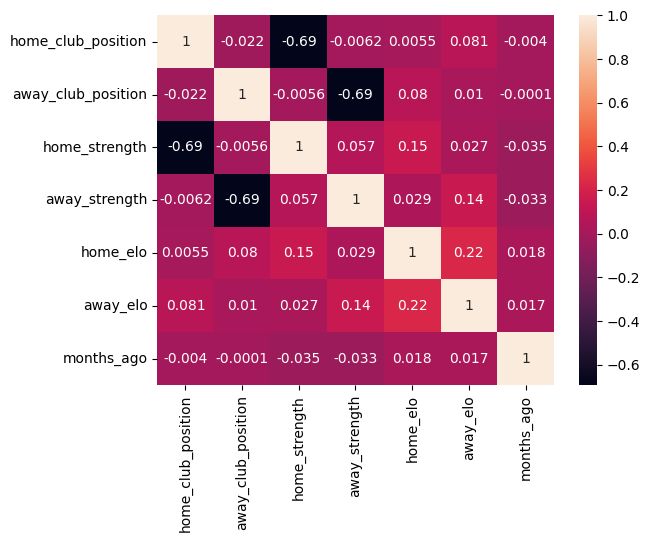

In [ ]:
get_object_for_predict, categorical_features, numerical_features, X_train, y_train, X_test, y_test, X_val, y_val = prep_4()

home_club_position    0
away_club_position    0
home_strength         0
away_strength         0
home_elo              0
away_elo              0
months_ago            0
dtype: int64
home_club_position    float64
away_club_position    float64
home_strength         float64
away_strength         float64
home_elo              float64
away_elo              float64
months_ago            float64
dtype: object
       home_club_position  away_club_position  home_strength  away_strength  \
11473                 3.0                10.0         0.1344        -0.7620   
27030                 9.0                16.0        -0.6066        -0.5120   
49657                 9.0                20.0        -0.8106        -1.1575   
64259                 9.0                20.0        -0.4364        -1.0513   
40066                 4.0                17.0         0.7629        -0.5834   
22832                 4.0                 1.0        -0.4452         0.2108   
51983                10.0                1

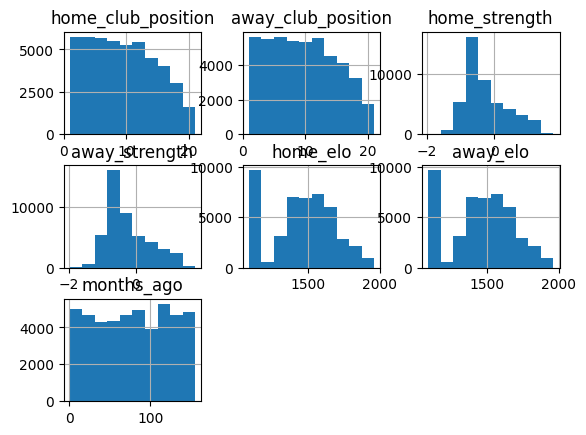

In [ ]:
print(X_train.isnull().sum())
print(X_train.dtypes)
X_train.hist()
print(X_train.sample(10))

# превращаем в np.array

In [ ]:
features = X_train.columns
X_train, X_test, X_val = X_train.to_numpy(), X_test.to_numpy(), X_val.to_numpy()

## Обучаем RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(criterion='gini', bootstrap=True, random_state=42, class_weight='balanced_subsample', max_features=0.5)
rfc.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Признак': features,
    'Важность': rfc.feature_importances_
})

feature_importances

,Признак,Важность
0,home_club_position,0.130810
1,away_club_position,0.125299
2,home_strength,0.156981
3,away_strength,0.157825
4,home_elo,0.117363
5,away_elo,0.114466
6,months_ago,0.197257


## Смотрим результаты RandomForestClassifier на тестовой выборке

In [ ]:
test_model(rfc, X_test, y_test)

Общая доля верно классифицированных исходов матчей: 0.56
Доля правильно предсказанных ничей: 0.29
Доля правильно предсказанных побед домашней команды: 0.63
Доля правильно предсказанных побед гостевой команды: 0.54
Доля фактически наступивших ничей, которые были верно предсказаны: 0.15
Доля фактически наступивших побед домашней команды, которые были верно предсказаны: 0.75
Доля фактически наступивших побед гостевой команды, которые были верно предсказаны: 0.59
F1-мера для ничей: 0.2
F1-мера для побед домашней команды: 0.68
F1-мера для побед гостевой команды: 0.56
Средняя F1-мера: 0.48
Средняя максимальная вероятность: 0.6
Средняя уверенность в предсказании: 0.35


Смотрим результаты RandomForestClassifier на валидационной выборке (актуальные матчи)

In [ ]:
test_model(rfc, X_val, y_val)

Общая доля верно классифицированных исходов матчей: 0.51
Доля правильно предсказанных ничей: 0.33
Доля правильно предсказанных побед домашней команды: 0.54
Доля правильно предсказанных побед гостевой команды: 0.52
Доля фактически наступивших ничей, которые были верно предсказаны: 0.16
Доля фактически наступивших побед домашней команды, которые были верно предсказаны: 0.68
Доля фактически наступивших побед гостевой команды, которые были верно предсказаны: 0.54
F1-мера для ничей: 0.22
F1-мера для побед домашней команды: 0.6
F1-мера для побед гостевой команды: 0.53
Средняя F1-мера: 0.45
Средняя максимальная вероятность: 0.56
Средняя уверенность в предсказании: 0.28


Использование модели. На вход подаются коды клубов (сделано для удобства) Из уже доступных датасетов или стороних ресурсов составляется объект. Модель делает предикт для этого объекта.

In [ ]:
def predict_match(home_code, away_code):
  x = get_object_for_predict(home_code, away_code)
  probabilities = rfc.predict_proba(x)[0]
  for i in range(len(probabilities)):
    print(f"{target_dict[i]}: {probabilities[i]}")